# Clustering

In [118]:
# General modules
import os

# Data wrangling
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt 

# Image processing
from PIL import Image
import zegamiML
        
# Dimensionality reduction
from sklearn.decomposition import PCA 
from sklearn.manifold import MDS, TSNE, Isomap
from sklearn.preprocessing import scale
import umap

# Clustering
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans, MeanShift, DBSCAN
import hdbscan
from scipy.cluster.hierarchy import dendrogram, linkage

# Plotting
from mpl_toolkits.mplot3d import Axes3D

In [3]:
zt = pd.read_csv("./test_data/zegami.tab", sep = "\t", header = 0)
zt.head()

,id,x,y,disease,path
0,0,3943.586594,-2378.194352,CAD,64_BullsEye.png
1,1,1617.265459,-339.951244,CAD,20_BullsEye.png
2,2,3774.299893,-1465.415170,CAD,17_BullsEye.png
3,3,2182.320656,-1604.897623,CAD,96_BullsEye.png
4,4,6509.727480,1997.538891,CAD,50_BullsEye.png


In [4]:
zt.describe()

,id,x,y
count,127.000000,1.270000e+02,1.270000e+02
mean,63.000000,-4.724412e-08,-7.873966e-09
std,36.805797,3.473482e+03,2.376548e+03
min,0.000000,-5.064702e+03,-5.990448e+03
25%,31.500000,-3.020156e+03,-1.290637e+03
50%,63.000000,-8.954199e+02,3.123476e+02
75%,94.500000,2.303134e+03,1.577495e+03
max,126.000000,9.040996e+03,6.131664e+03


## Process images

In [5]:
image_path = "./test_data/out/"
image_col = 'path'

images = [os.path.join(image_path, image) for image in zt[image_col]]

In [6]:
data, skipped = zegamiML.process_images(images)

In [18]:
full_df = pd.concat([zt, pd.DataFrame(data)], axis = 1)
full_df.to_csv("./full_df.tsv", sep = '\t', index = False)

### Reduce dimensions

# Theoretical introduction to dimensionality reduction 

In brief, dimensionality reduction is a task of representing multidimensional data (for example single cell expression data) into  low dimensional (1-3D) space.

## Linear methods
### PCA
**Principal Components Analysis (PCA)** is a dimensioanlity reduction method using **Singular Value Decomposition (SVD)**.

1. Step 1. Center the data

    Calculate the means of each variable and  place the center is on top of the oigin in the graph. I.e. values are expressed relative to the means.

1. Step 2. Find PC1

    Find a line that goes through the origin and project points onto it. Then, rotate the line such that you maximize the distance of each point projected to that line from teh origin.

    PC1 is a linear combination of the variables in the dataset.

    **Eigenvector for PC1** (also called Singular Vector) is a unit vector of the best fitted line. And the proporions of variables contributing to this vector are called **Loading Scores**. Loading Scores explain which variable(s) drive(s) the separation with a given componenet.

    **Eigenvalue** is the sum of squares of distances of points projected to a line from the origin. **Singular Value** is a square root of the Eigenvalue

1. Step 3. Find the rest of principal components 

    Having found PC1, find PC2 by finding a line that is perpendicular to PC1, goes through the origin  and maxiizes the distances of each projected point from origin. Find the following principal components, knowing that PC3 is perpendicular to PC2&PC1 and goes through the origin etc.

The number of principal components is limited by the number of variables, or samples (whichever is smaller).

### MDS 

(sklearn implementation uses the non-metric MDS, conversly in R the default MDS is a classical/metric MDS)
## Non-linear methods
### tSNE - t-distributed Stochastic Neighbor Embedding

Step 1. Determining the similarity of the points.

For each point a normal curver centered on that point is constructed. The width of this curve is based on the density of the surrounding data points which is related to the perplecity argument (i.e. the bigger the perplexity the wider the curve, more points are included in estimating the density).  Then, unscaled similarity is expressed as the height of that normal curve within the distance to each of the other points. Next, for each point the similiarites are scaled to add up to 1. Because the curve is consrtucted for each point separately, the AB and BA distances might be different, therefore the algortihm averags them out.

Similarity between point A and A is expressed as 0. 

Step 2. 

Next, the points are randomly projected on the  chosen dimensions (line in 1D, plane in 2D and space in 3D). Like in the step 1, the similarities are calculated by measuring the heaight of the distribution curve. Only this time, the curve is a t-distribution curve.

Now, there are two similarities matrices - one from Step 1 (D1, based on normal distribution)  and one from this Step (D2, based on t-distribution). 

Step 3. Moving the points 

The positions of the points on the projection space are changed so the matrix D2 resembles matrix D1. Points are move one at the time. The D2 is recalculated after each move (?). 


#### Perplexity

perplexity - According to the text on ["How to Use t-SNE Effectively"](https://distill.pub/2016/misread-tsne/): "The parameter is, in a sense, a guess about the number of close neighbors each point has." 

<img src=https://scikit-learn.org/stable/_images/sphx_glr_plot_t_sne_perplexity_001.png width="700">

t-SNE can be potentially used if we use a non-distance based clustering techniques like FMM (Finite Mixture Models) or DBSCAN (Density-based Models). As you correctly note, in such cases, the t-SNE output can quite helpful. The issue in these use cases is that some people might try to read into the cluster placement and not only the cluster membership. As the global distances are lost, drawing conclusions from cluster placement can lead to bogus insights. Notice that just saying: "hey, we found all the 1s cluster together" does not offer great value if cannot say what they are far from. If we just wanted to find the 1's we might as well have used classification to begin with (which bring us back to the use of autoencoders). from [here](https://stats.stackexchange.com/a/340185)
    
### UMAP
### Isomap


![](https://imgs.xkcd.com/comics/artifacts.png)

In [19]:
analysis_types = ['PCA', 'MDS', 'tSNE', 'umap', "Isomap"]

def plot_all(df_with_coord, labels = None, types = analysis_types):
    fig = plt.figure(figsize = (25, 5))
    for i in range(0, len(types)):
        analysis_type = types[i]
        # plotting
        plt.subplot(1, len(types), i + 1)
        if labels is not None:
            plt.scatter(df_with_coord['x_' + analysis_type], 
                        df_with_coord['y_' + analysis_type], 
                        c = labels)
        else:
            plt.scatter(df_with_coord['x_' + analysis_type], 
                        df_with_coord['y_' + analysis_type])
        plt.title(analysis_type)
    return fig

def reduce_dim(data, zt_in, types = analysis_types):
    zt_out = zt_in
    for i in range(0, len(types)):
        analysis_type = types[i]
        reduced_df = zegamiML.reduce_dimensions(data, analysis_type = analysis_type)
        
        # merge input and reduced data frames
        reduced_df = reduced_df.rename(index = str, 
                                       columns = {'x': 'x_' + analysis_type, 
                                                  'y': 'y_' + analysis_type})
        reduced_df[image_col] = [os.path.basename(image_fp) for image_fp in images
                                 if image_fp not in skipped]
        
        
        zt_out = pd.merge(zt_out, reduced_df, on = image_col, how = 'outer')
    
    return zt_out

In [35]:
zt_out = reduce_dim(data, zt)

In [21]:
zt_out.head()

,id,x,y,disease,path,x_PCA,y_PCA,x_MDS,y_MDS,x_tSNE,y_tSNE,x_umap,y_umap,x_Isomap,y_Isomap
0,0,3943.586594,-2378.194352,CAD,64_BullsEye.png,3968.864602,-2231.729437,6695.475154,-4901.763567,4394.564453,-2001.876099,-9.947999,2.518446,8670.957596,-14032.310012
1,1,1617.265459,-339.951244,CAD,20_BullsEye.png,1508.307237,-463.023256,2590.012109,200.231197,2023.169922,-755.816711,-8.343033,2.930963,13718.040168,6916.207609
2,2,3774.299893,-1465.415170,CAD,17_BullsEye.png,3817.796173,-1480.926827,6054.486529,-3249.385803,3453.005371,-1448.791382,-9.208088,2.866745,20293.080285,-6205.318856
3,3,2182.320656,-1604.897623,CAD,96_BullsEye.png,2072.701594,-1724.537388,4525.202428,2992.282565,1472.629272,-1950.116455,-7.769613,1.944518,28241.453612,6097.902881
4,4,6509.727480,1997.538891,CAD,50_BullsEye.png,6547.194896,2016.294045,11360.445513,-488.689771,6441.558105,1775.712646,-10.674695,3.617222,16662.553313,-17447.514830


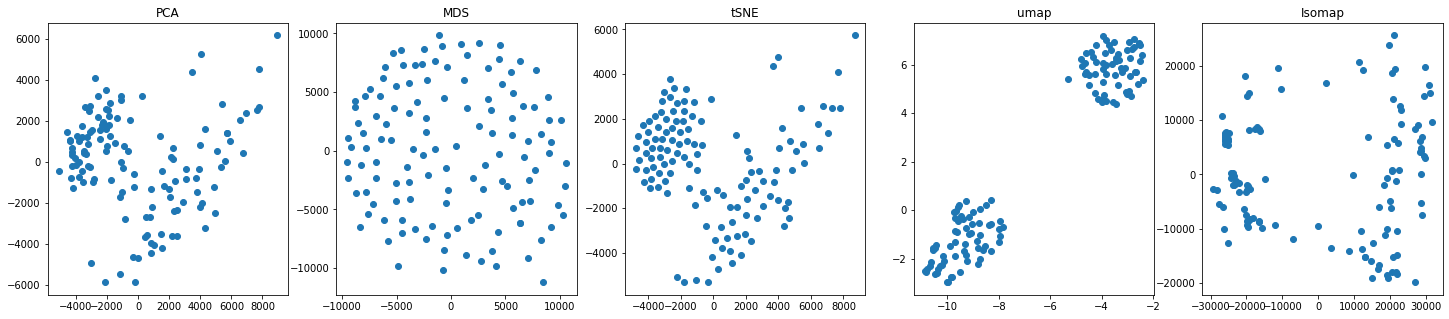

In [36]:
figur = plot_all(zt_out)

### Quality of DR

In [ ]:
def n_pcs(evr, ratio = 0.7, plot = False, PCs = 0):
    cs_evr = np.cumsum(evr)
    pcs_expl = min([i[0] for i, x in np.ndenumerate(cs_evr) if x > ratio]) + 1
    if PCs == 0:
        PCs = pcs_expl
    if plot:
        var_explained = round(cs_evr[PCs-1]*100, 0)
        plt.bar(range(1, len(evr[0:PCs])+1), 
                evr[0:PCs] * 100)
        plt.title(f'Scree plot\nVariance explained: {var_explained}%')
        plt.ylabel('% of variance explained')
        plt.xlabel('Principal Component')
        plt.xticks(range(1, len(evr[0:PCs])+1))
    return pcs_expl

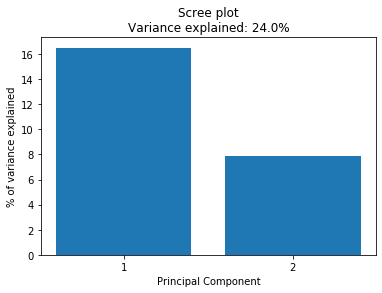

In [112]:
pca = PCA()
pca.fit_transform(data)

pcs = n_pcs(pca.explained_variance_ratio_, plot = True, PCs = 2)

50.0% of variance is explained by 12 PCs.


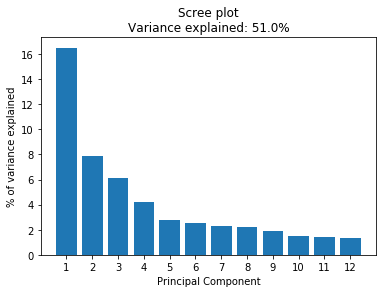

In [115]:
rt = 0.5
pcs = n_pcs(pca.explained_variance_ratio_, plot = True, ratio = rt)

print(f'{rt*100}% of variance is explained by {pcs} PCs.')

In [132]:
def plot_1d_to_3d(method = "PCA"):
    method = method.upper()
    methods = ["PCA", "TSNE", "UMAP"]
    if method not in methods:
        raise ValueError(f'{method} not suppoerted!')
    figr = plt.figure(figsize = (15, 5))
    for i in range(0, 3):
        if method == "PCA":
            reducer = PCA(n_components = i+1)
        elif method == "TSNE":
            reducer = TSNE(n_components = i+1)
        else: # method == "UMAP"
            reducer = umap.UMAP(n_components = i+1)
        X = reducer.fit_transform(data)
        if i == 0:
            ax = plt.subplot(1, 3, i + 1)
            ax.scatter(X[:,0], range(len(X)))
        elif i == 1:
            ax = plt.subplot(1, 3, i + 1)
            ax.scatter(X[:,0], X[:,1])
        else:
            ax = plt.subplot(1, 3, i + 1, projection = '3d')
            ax.scatter(X[:,0], X[:,1], X[:,2], s = 100)
        plt.title(f'{i+1}D')
    figr.suptitle(method)
    figr.show()

/home/kzkedzierska/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


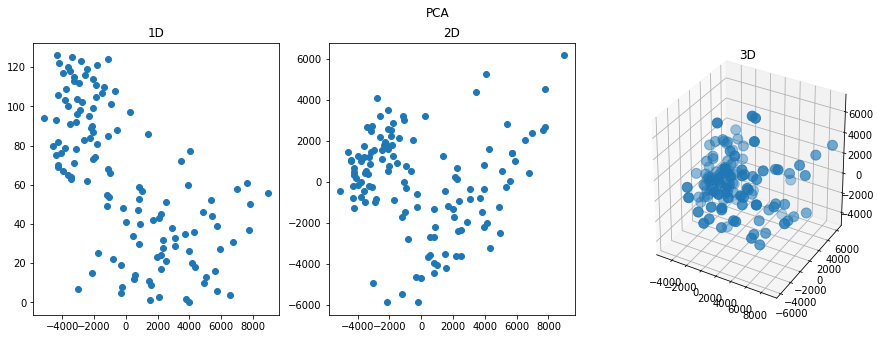

In [133]:
plot_1d_to_3d("PCA")

/home/kzkedzierska/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


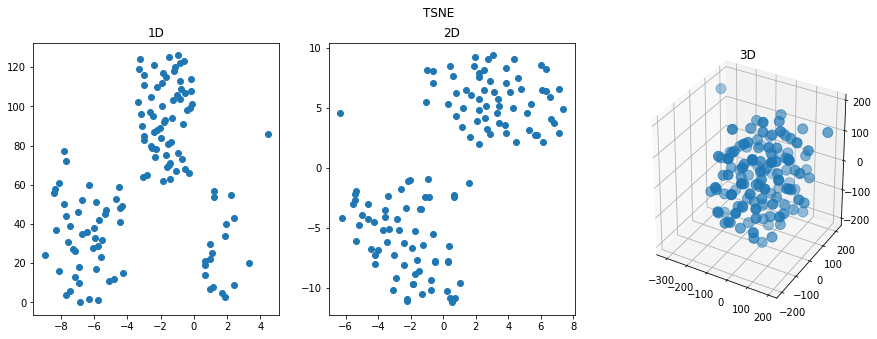

In [136]:
plot_1d_to_3d("tSNE")

/home/kzkedzierska/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


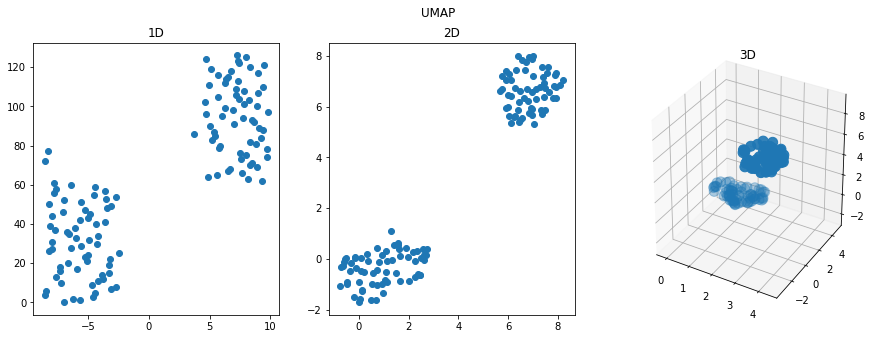

In [137]:
plot_1d_to_3d("umap")

### Clustering

#### K-means

In [ ]:
kmeans = KMeans(n_clusters = 2, random_state = 7).fit(data)
labels = kmeans.labels_

In [ ]:
collections.Counter(labels)

In [ ]:
figur2 = plot_all(zt_out, labels = labels)

##### Optimal k

In [ ]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
def optimalK(data, nrefs=3, maxClusters=15):
    # copied from: https://anaconda.org/milesgranger/gap-statistic/notebook
    
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [ ]:
optimalK(np.array(data))

#### MeanShift

In [ ]:
clustering = MeanShift(bandwidth = 50).fit(data)
labels = clustering.labels_

In [ ]:
#collections.Counter(labels)

In [ ]:
figur3 = plot_all(zt_out, labels = labels)

#### Density-Based Spatial Clustering of Applications with Noise 

In [ ]:
clustering = DBSCAN(eps = 10000, min_samples = 2).fit(data)
labels = clustering.labels_

In [ ]:
collections.Counter(labels)

In [ ]:
figur4 = plot_all(zt_out, labels = labels)

In [ ]:
dist_data = distance_matrix(data, data)

In [ ]:
a = np.hstack(dist_data)

In [ ]:
plt.hist(a, bins = 'auto')
plt.show()

#### HDBSCAN

In [ ]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=500).fit_predict(data)

In [ ]:
collections.Counter(hdbscan_labels)

In [ ]:
plt.scatter(zt['x'], zt['y'])